**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

**Set Seed for Reproducibility**

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark=False

set_seed()

**Set Device (GPU)**

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Uisng device: {device}")

Uisng device: cuda


**Setting up the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_path= '/content/drive/MyDrive/EuroSAT_RGB.zip'
extract_path= '/content/EuroSAT_RGB'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
for folder_name in os.listdir(extract_path):
  print(folder_name)

EuroSAT_RGB


In [ ]:
print(os.listdir("/content"))

['.config', 'EuroSAT_RGB', 'drive', 'sample_data']


In [ ]:
root_dir="/content/EuroSAT_RGB/EuroSAT_RGB"
print(os.listdir(root_dir))

['AnnualCrop', 'HerbaceousVegetation', 'Residential', 'Forest', 'PermanentCrop', 'Pasture', 'Industrial', 'River', 'SeaLake', 'Highway']


**CREATING A DATAFRAME**

In [ ]:


image_paths=[]
labels=[]


# Creating a list of image paths and their labels
for class_name in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, class_name)

    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            image_paths.append(img_path)
            labels.append(class_name)


#Creating a dataframe
df=pd.DataFrame({
    'image_path':image_paths,
    'label':labels
})


df.head()

,image_path,label
0,/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/An...,AnnualCrop
1,/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/An...,AnnualCrop
2,/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/An...,AnnualCrop
3,/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/An...,AnnualCrop
4,/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/An...,AnnualCrop


In [ ]:
df.tail()

,image_path,label
26995,/content/EuroSAT_RGB/EuroSAT_RGB/Highway/Highw...,Highway
26996,/content/EuroSAT_RGB/EuroSAT_RGB/Highway/Highw...,Highway
26997,/content/EuroSAT_RGB/EuroSAT_RGB/Highway/Highw...,Highway
26998,/content/EuroSAT_RGB/EuroSAT_RGB/Highway/Highw...,Highway
26999,/content/EuroSAT_RGB/EuroSAT_RGB/Highway/Highw...,Highway


In [ ]:
df.shape

(27000, 2)

**VSUALIZING SOME DATA**

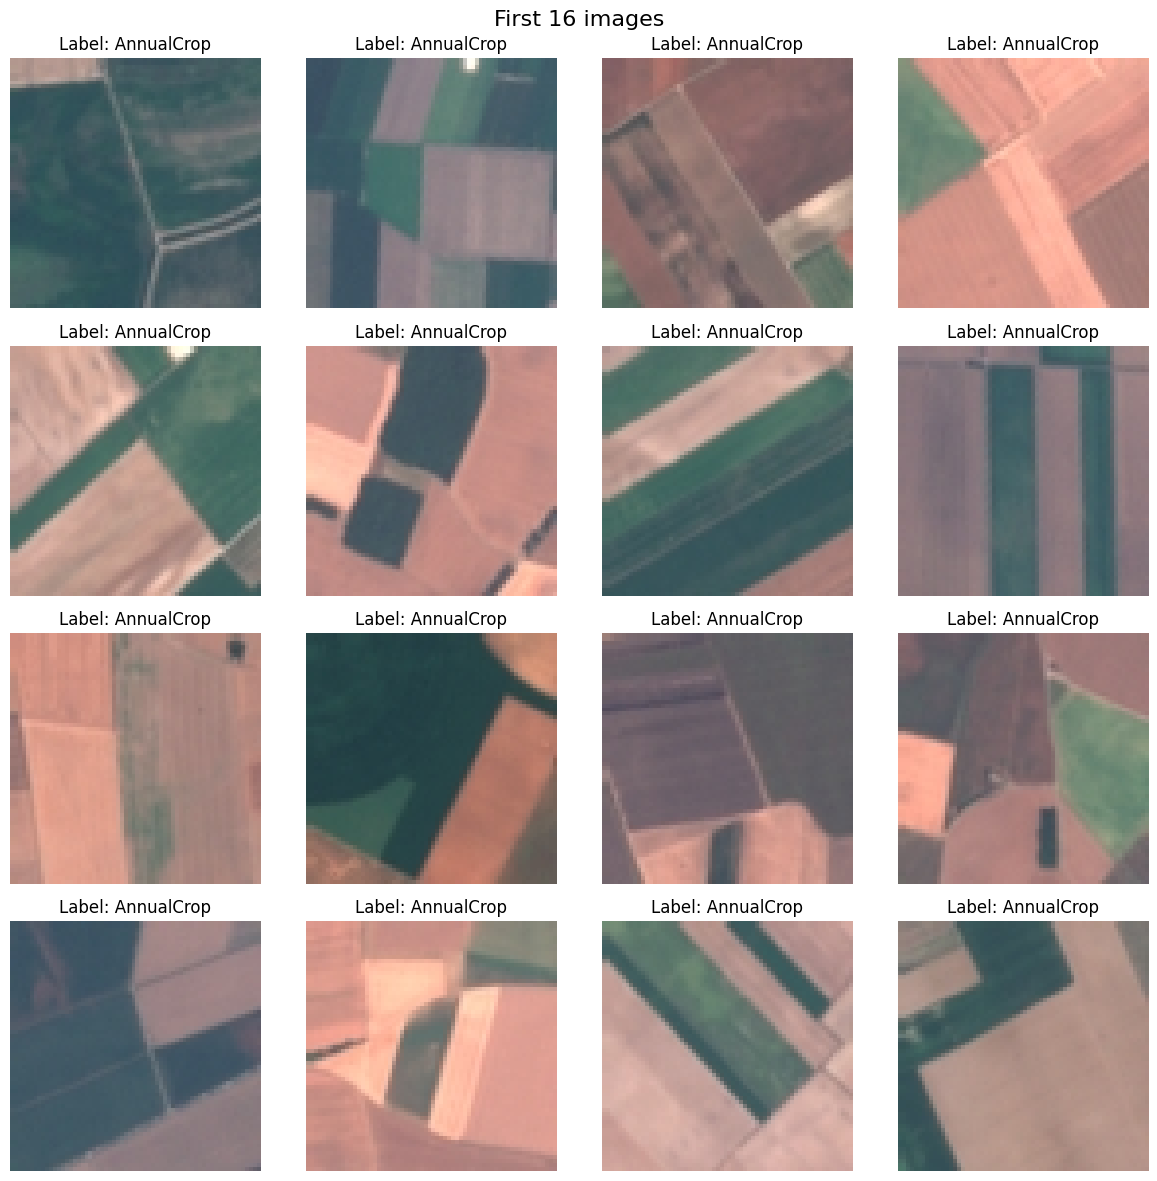

In [ ]:
#Creating  a4*4 grid of images:
fig,axes=plt.subplots(4,4,figsize=(12,12))
fig.suptitle("First 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
  image_path=df.iloc[i, 0]
  img=Image.open(image_path)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(f"Label: {df.iloc[i,1]}")

plt.tight_layout()
plt.show()

**CHECKING FOR EMPTY VALUES**

In [ ]:
df.isnull().sum()

,0
image_path,0
label,0


**DEFINING X AND Y**

In [ ]:
X=df.iloc[:,0].values
y=df.iloc[:,1].values

**LABEL ENCODING**

In [ ]:
le=LabelEncoder()
y=le.fit_transform(y)

In [ ]:
print(le.classes_)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


**TRAIN TEST SPLIT**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=y)

**DEFINING TRANSFORMATIONS**

In [ ]:
custom_transform=transforms.Compose([
    transforms.Resize(256),      #Resizing shorter side to 256px
    transforms.CenterCrop(224),  #Croping to 224x224 (VGG16 input size)
    transforms.ToTensor(),       #Converting to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
    transforms.RandomRotation(degrees=15), # Added degrees argument
    transforms.Normalize(       # Normalizing for ImageNet pretrained VGG16
        mean=[0.485,0.456,0.406],
        std=[0.229, 0.224, 0.225]
    )
])

**CUSTOM DATASET CLASS**

In [ ]:
class CustomDataset(Dataset):

  def __init__(self,image_paths, labels, transform=None):
    self.image_paths=image_paths
    self.labels=labels
    self.transform=transform


  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self,index):

    #Step 1: Load image from disk
    image_path=self.image_paths[index]
    image=Image.open(image_path).convert('RGB')

    #Step 2: Apply Transformations:
    image=self.transform(image)

    label=torch.tensor(self.labels[index], dtype=torch.long)

    return image, label




**CustomDataset object for train and test**

In [ ]:
train_dataset=CustomDataset(X_train,y_train,transform=custom_transform)
test_dataset=CustomDataset(X_test,y_test,transform=custom_transform)

**DATALOADER FOR TRAIN AND TEST**

In [ ]:
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=False)

**DATALOADER FOR TRAIN AND TEST**

In [ ]:
sample_img, _=train_dataset[0]
input_size=sample_img.numel()
print(f"Input size: {input_size}")

Input size: 150528


**FETCH THE PRE-TRAINED MODEL**

In [ ]:
import torchvision.models as models

vgg16=models.vgg16(pretrained=True)

vgg16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

#**DEFINING THE MODEL**

**FREEZING THE PARAMETERS i.e. THE FEATURE EXTRACTION PART OF THE PRETRAINED MODEL**

In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad=False

**REPLACING THE CLASSIFIER BLOCK OF PRETRAINED MODEL WITH OUR CLASSIFIER**





It is done because the ImageNet data has 1000 classes and my dataset has 10 classes.

In [ ]:
vgg16.classifier=nn.Sequential(

    nn.Linear(25088,1024),    #Ist layer
    nn.ReLU(),
    nn.Dropout(0.6),

    nn.Linear(1024, 512),    #2nd layer
    nn.ReLU(),
    nn.Dropout(0.6),


    nn.Linear(512,10)       #3rd layer
)

vgg16.to(device)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**DEFINING IMPORTANT PARAMETERS**

In [ ]:
learning_rate=0.0001
epochs=10

In [ ]:

#Loss Function:
criterion=nn.CrossEntropyLoss()

#Optimizer:
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learning_rate,weight_decay=1e-4)

**TRAINING LOOP**

In [ ]:
train_losses = []
test_accuracies = []






for epoch in range(epochs):
  total_epoch_loss=0

  vgg16.train()

  for batch_features, batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    #Forward pass
    outputs=vgg16(batch_features)

    #Computing loss:
    loss=criterion(outputs,batch_labels)

    #Reset Gradients:
    optimizer.zero_grad()
    #Backward pass
    loss.backward()

    #Update weights:
    optimizer.step()

    total_epoch_loss+=loss.item()

  avg_loss=total_epoch_loss/len(train_loader)
  train_losses.append(avg_loss)








  #FOR PLOTTING LOSS AND ACCURACY
  vgg16.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)


      outputs = vgg16(batch_features)  #Forward pass
      _, predicted = torch.max(outputs, 1)  #Getting predicted class


      total += batch_labels.size(0)     #Total samples
      correct += (predicted == batch_labels).sum().item()  #Correct predictions

  accuracy = correct / total #Accuracy for this epoch
  test_accuracies.append(accuracy)

  print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy:{accuracy:.4f}")

Epoch: 1, Loss: 0.8718, Accuracy:0.8715
Epoch: 2, Loss: 0.4481, Accuracy:0.8907
Epoch: 3, Loss: 0.3744, Accuracy:0.9017
Epoch: 4, Loss: 0.3528, Accuracy:0.9131
Epoch: 5, Loss: 0.3312, Accuracy:0.9037
Epoch: 6, Loss: 0.3131, Accuracy:0.9183
Epoch: 7, Loss: 0.2996, Accuracy:0.9124
Epoch: 8, Loss: 0.2935, Accuracy:0.9211
Epoch: 9, Loss: 0.2909, Accuracy:0.9131
Epoch: 10, Loss: 0.2799, Accuracy:0.9176


**SAVING THE MODEL**

In [ ]:
torch.save(vgg16.state_dict(),'eurostat_vgg16.pth')

In [ ]:
vgg16.load_state_dict(torch.load('eurostat_vgg16.pth'))
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**MODEL EVALUATION ON TEST DATA**

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100*correct / total:.2f}")

Test Accuracy: 91.50


**MODEL EVALUATION ON TRAIN DATA**

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Train Accuracy: {100*correct / total:.2f}")

Train Accuracy: 93.12


**MAKING PREDICTION ON SINGLE EUROSAT IMAGE**

Predicted Class index: 7
Predicted class label: Residential


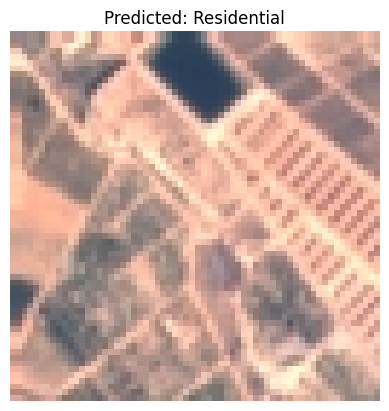

In [ ]:
# 1. Class labels
class_names=[
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'

]

# 2. Transform
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    )
])

# 3. Load and preprocess image
image_path="/content/EuroSAT_RGB/EuroSAT_RGB/PermanentCrop/PermanentCrop_98.jpg" # Corrected image path
image=Image.open(image_path).convert('RGB')
input_tensor=transform(image).unsqueeze(0)
input_tensor=input_tensor.to(device)



#Predict:
vgg16.eval()
with torch.no_grad():
  outputs=vgg16(input_tensor)
  predicted_class=torch.argmax(outputs,dim=1).item()


#Output result:
print(f"Predicted Class index: {predicted_class}")
print(f"Predicted class label: {class_names[predicted_class]}")



plt.imshow(image)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

**PLOTTING LOSS AND ACCURACY**

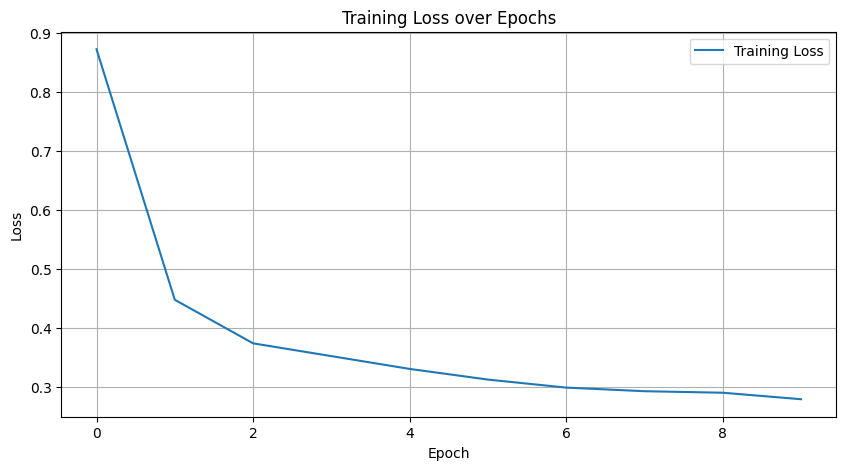

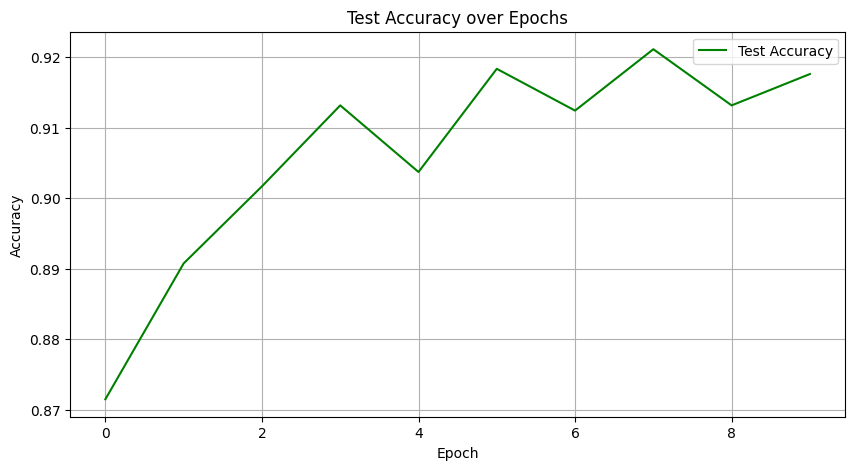

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()


**CONFUSION MATRIX AND CLASSIFICATION REPORT**

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.94      0.93       600
              Forest       0.98      0.95      0.96       600
HerbaceousVegetation       0.87      0.92      0.89       600
             Highway       0.86      0.80      0.83       500
          Industrial       0.94      0.95      0.95       500
             Pasture       0.93      0.91      0.92       400
       PermanentCrop       0.94      0.81      0.87       500
         Residential       0.97      0.95      0.96       600
               River       0.79      0.92      0.85       500
             SeaLake       0.97      0.98      0.98       600

            accuracy                           0.92      5400
           macro avg       0.92      0.91      0.91      5400
        weighted avg       0.92      0.92      0.92      5400



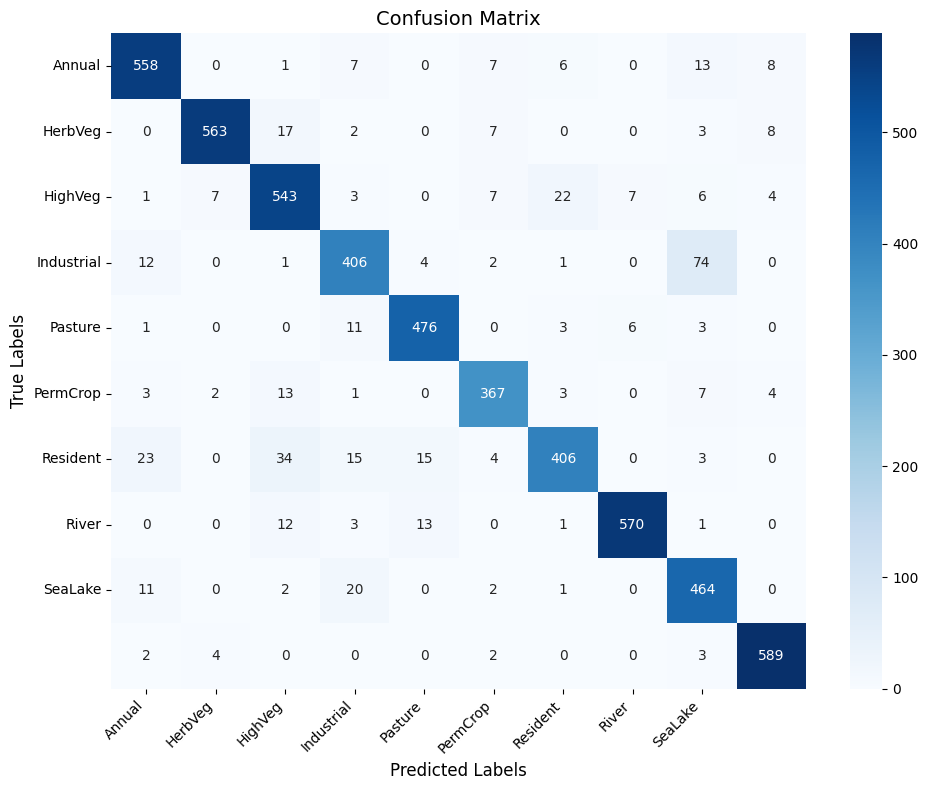

In [ ]:
vgg16.eval()


class_names=le.classes_

all_preds=[]
all_labels=[]


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs=inputs.to(device)
    labels=labels.to(device)

    outputs=vgg16(inputs)
    _,preds=torch.max(outputs,1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

#Converting to nump arrays:
all_preds=np.array(all_preds)
all_labels=np.array(all_labels)


#Classification Report:
print("Classification Report")
print(classification_report(all_labels, all_preds, target_names=class_names))

#Confusion Matrix:
class_names_short = [
    'Annual', 'HerbVeg', 'HighVeg', 'Industrial',
    'Pasture', 'PermCrop', 'Resident', 'River', 'SeaLake'
]

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=class_names_short,
            yticklabels=class_names_short,
            ax=ax)


ax.set_xticklabels(class_names_short, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(class_names_short, rotation=0, fontsize=10)

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()  # Adjusts layout to avoid label cut-off
plt.savefig("confusion_matrix_clean.png", dpi=300)
plt.show()